In [78]:
import pandas as pd
import openai
import numpy as np
import json
import os
from src.responses import completion_to_dict
from dotenv import load_dotenv
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

load_dotenv()

# Set the seed for reproducibility
SEED = 10


# Today's date for the filename
from datetime import datetime
today = datetime.today().strftime('%Y%m%d')[2:]


# Data Input

In [2]:
# Read in the arXiv metadata
with open("data/arxiv_metadata/filtered/march_2024_ai_hc_cy_peer_reviewed_sampled.json") as json_data:
    metadata = json.load(json_data)
    json_data.close()

# Convert JSON to DataFrame
metadata_df = pd.DataFrame.from_dict(metadata, orient='index')

metadata_df.head()

,arxiv_id,url,title,summary,updated,published,authors,comments,categories,primary_category,doi,journal_ref,peer_reviewed
0,2403.16190v1,http://arxiv.org/abs/2403.16190v1,Logic-based Explanations for Linear Support Ve...,Support Vector Classifier (SVC) is a well-know...,1711293284000,1711293284000,"[Francisco Mateus Rocha Filho, Thiago Alves Ro...","16 pages, submitted to BRACIS 2023 (Brazilian ...","[cs.AI, cs.LG, cs.LO, I.2.4; I.2.6]",cs.AI,10.1007/978-3-031-45368-7_10,None,True
1,2307.05300v4,http://arxiv.org/abs/2307.05300v4,Unleashing the Emergent Cognitive Synergy in L...,Human intelligence thrives on cognitive synerg...,1711463553000,1689086719000,"[Zhenhailong Wang, Shaoguang Mao, Wenshan Wu, ...",Accepted as a main conference paper at NAACL 2024,"[cs.AI, cs.CL]",cs.AI,None,None,True
2,2403.16750v1,http://arxiv.org/abs/2403.16750v1,"All Artificial, Less Intelligence: GenAI throu...",Modern hardware designs have grown increasingl...,1711373004000,1711373004000,"[Deepak Narayan Gadde, Aman Kumar, Thomas Nala...",Published in DVCon U.S. 2024,[cs.AI],cs.AI,None,None,True
3,2311.10112v2,http://arxiv.org/abs/2311.10112v2,zrLLM: Zero-Shot Relational Learning on Tempor...,Modeling evolving knowledge over temporal know...,1710517087000,1700083515000,"[Zifeng Ding, Heling Cai, Jingpei Wu, Yunpu Ma...",Accepted to NAACL 2024 main conference,"[cs.AI, cs.CL, cs.LG]",cs.AI,None,None,True
4,2310.08992v3,http://arxiv.org/abs/2310.08992v3,CodeChain: Towards Modular Code Generation Thr...,Large Language Models (LLMs) have already beco...,1710386949000,1697192268000,"[Hung Le, Hailin Chen, Amrita Saha, Akash Goku...",Accepted to ICLR 2024,"[cs.AI, cs.CL, cs.PL]",cs.AI,None,None,True


In [3]:
# Light text cleaning so that it can be proprely fed into the model
metadata_df['summary'] = metadata_df['summary'].str.replace('\n', ' ')
metadata_df['summary'] = metadata_df['summary'].str.replace('\r', ' ')
metadata_df['summary'] = metadata_df['summary'].str.replace('\t', ' ')
metadata_df['summary'] = metadata_df['summary'].str.replace('  ', ' ')
metadata_df['summary'] = metadata_df['summary'].str.strip()


In [4]:
# Add in a column mapping the primary category to a more human readable format
category_map = {
    'cs.AI': 'Artificial Intelligence',
    'cs.CY': 'Computers and Society',
    'cs.HC': 'Human-Computer Interaction'
}

metadata_df['primary_category_readable'] = metadata_df['primary_category'].map(category_map)

metadata_df.head(3)

,arxiv_id,url,title,summary,updated,published,authors,comments,categories,primary_category,doi,journal_ref,peer_reviewed,primary_category_readable
0,2403.16190v1,http://arxiv.org/abs/2403.16190v1,Logic-based Explanations for Linear Support Ve...,Support Vector Classifier (SVC) is a well-know...,1711293284000,1711293284000,"[Francisco Mateus Rocha Filho, Thiago Alves Ro...","16 pages, submitted to BRACIS 2023 (Brazilian ...","[cs.AI, cs.LG, cs.LO, I.2.4; I.2.6]",cs.AI,10.1007/978-3-031-45368-7_10,None,True,Artificial Intelligence
1,2307.05300v4,http://arxiv.org/abs/2307.05300v4,Unleashing the Emergent Cognitive Synergy in L...,Human intelligence thrives on cognitive synerg...,1711463553000,1689086719000,"[Zhenhailong Wang, Shaoguang Mao, Wenshan Wu, ...",Accepted as a main conference paper at NAACL 2024,"[cs.AI, cs.CL]",cs.AI,None,None,True,Artificial Intelligence
2,2403.16750v1,http://arxiv.org/abs/2403.16750v1,"All Artificial, Less Intelligence: GenAI throu...",Modern hardware designs have grown increasingl...,1711373004000,1711373004000,"[Deepak Narayan Gadde, Aman Kumar, Thomas Nala...",Published in DVCon U.S. 2024,[cs.AI],cs.AI,None,None,True,Artificial Intelligence


In [ ]:
# Read in the prompt templates for this task. These will need to be converted to f-strings.

with open("data/llm_prompts/jargon_identifyv2.json") as json_data:
    jargon_prompts = json.load(json_data)
    json_data.close()

# Preview
jargon_prompts
    

In [ ]:
# Read in reader profiles
with open('data/llm_prompts/jargon_readersv2.json', 'r') as file:
    readers = json.load(file)

# Output the data
for reader in readers:
    print(f"Description: {reader['reader_description']}")

# GPT4 Setup


In [ ]:
from openai import OpenAI

# Setup client
client = OpenAI(
    api_key = os.getenv("OPENAI_KEY"),
)

In [ ]:
# Model and decoding params
GPT_MODEL = "gpt-4-turbo"
MAX_TOKENS = 512
TEMPERATURE = 1.0

# Extract prompts from the dict
system_prompt = jargon_prompts['system_prompt']
query_prompt = jargon_prompts['query_prompt']


# Calling the API

In [ ]:
print(system_prompt)

In [ ]:
%%time
# Iterate over the abstracts in thr DF + the reader profiles to generate the prompts and responses

# Initialize a list to store the results
results = []

# Iterate over the metadata -- try two rows first
for idx, row in metadata_df.iterrows():

    # Extract abstract metadata
    arxiv_id = row['arxiv_id']
    abstract_text = row['summary']
    primary_category_readable = row['primary_category_readable']

    # Iterate over the reader profiles
    for reader in readers:

        # Extract reader ID
        reader_id = reader['reader_id']

        # Print everything extracted so far
        # print(f"arXiv ID: {arxiv_id}")
        # print(f"Abstract: {abstract_text}")
        # print(f"Primary Category: {primary_category_readable}")
        # print(f"Reader ID: {reader_id}")

        # Edit the system prompt once more
        filled_system_prompt = system_prompt.format(
            reader_description=reader['reader_description'],
            # reader_expertise=reader['reader_expertise'], 
            primary_category_readable=primary_category_readable
        )

        # Fill in the query prompt
        filled_query_prompt = query_prompt.format(
            abstract_text=abstract_text
        )

        # Create the messages
        messages = [
            {"role": "system", "content": filled_system_prompt},
            {"role": "user", "content": filled_query_prompt},
        ]

        # Generate the completion
        completion = client.chat.completions.create(
            model=GPT_MODEL,
            seed=SEED,
            max_tokens=MAX_TOKENS,
            temperature=TEMPERATURE,
            messages=messages
        )

        # Convert the response to a dictionary
        completion_dict = completion_to_dict(completion)
        
        # Store the result
        results.append({
            'arxiv_id': arxiv_id,
            'reader_id': reader_id,
            'messages': messages,
            'completion': completion_dict
        })
        
    

In [ ]:
# Today's date for the filename
from datetime import datetime
today = datetime.today().strftime('%Y%m%d')[2:]

# Save to JSON with indenting
with open(f'data/llm_outputs/{today}_march_2024_ai_hc_cy_peer_reviewed_sampled_jargon_list.json', 'w') as file:
    json.dump(results, file, indent=4)




# Evaluation of the Jargon Identification


## Some basic data processing

In [5]:
# Read in the results
with open("data/llm_outputs/240525_march_2024_ai_hc_cy_peer_reviewed_sampled_jargon_list.json", "r") as file:
    results = json.load(file)

In [6]:
# Make result into a df that we like
results_df = [] 

for result in results:

    results_df.append(
        [result['arxiv_id'], result['reader_id'], result['completion']['content']]
    )

results_df = pd.DataFrame(results_df, columns=['arxiv_id', 'reader_id', 'gpt4_jargon_list'])
results_df.head()

,arxiv_id,reader_id,gpt4_jargon_list
0,2403.16190v1,rid0,"reject option strategy, formal guarantees, min..."
1,2403.16190v1,rid1,"linear classification problems, reject option ..."
2,2307.05300v4,rid0,"cognitive synergist, fine-grained personas, fa..."
3,2307.05300v4,rid1,"cognitive synergy, cognitive synergist, multi-..."
4,2403.16750v1,rid0,"Common Weakness Enumerations (CWEs), SystemVer..."


In [7]:
# Read in the human annotations
rid_0_jargon = pd.read_csv("data/human_annotations/march_2024_ai_hc_cy_peer_reviewed_sampled_jargon_list_rid0.csv")
rid_1_jargon = pd.read_csv("data/human_annotations/march_2024_ai_hc_cy_peer_reviewed_sampled_jargon_list_rid1.csv")

# Stack these two with only the relevant columns
rid_0_jargon['reader_id'] = 'rid0'
rid_1_jargon['reader_id'] = 'rid1'
human_annotations = pd.concat([rid_0_jargon, rid_1_jargon], axis=0)[['arxiv_id', 'reader_id', 'jargon terms']]
human_annotations.rename(columns={'jargon terms': 'human_jargon_list'}, inplace=True)

human_annotations.head()

,arxiv_id,reader_id,human_jargon_list
0,2403.16190v1,rid0,"correctness,minimality,Anchors"
1,2307.05300v4,rid0,"multi-turn,persona"
2,2403.16750v1,rid0,"common weakeness enumerations,SystemVerilog,Re..."
3,2311.10112v2,rid0,"temporal knowledge graphs,embedding-based TKGF..."
4,2310.08992v3,rid0,"pass@1,APPS,CodeContests"


In [8]:
results_df.shape, human_annotations.shape

((128, 3), (128, 3))

In [11]:
# Merge the human annotations with the LLM outputs
merged_humam_llm_jargon = pd.merge(
    results_df, human_annotations, on=['arxiv_id', 'reader_id'], how='inner')
merged_humam_llm_jargon.fillna("", inplace=True)

In [12]:
merged_humam_llm_jargon

,arxiv_id,reader_id,gpt4_jargon_list,human_jargon_list
0,2403.16190v1,rid0,"reject option strategy, formal guarantees, min...","correctness,minimality,Anchors"
1,2403.16190v1,rid1,"linear classification problems, reject option ...","reject option strategy,Anchors,heuristic algor..."
2,2307.05300v4,rid0,"cognitive synergist, fine-grained personas, fa...","multi-turn,persona"
3,2307.05300v4,rid1,"cognitive synergy, cognitive synergist, multi-...","Solo Performance Prompting,multi-turn,Chain-of..."
4,2403.16750v1,rid0,"Common Weakness Enumerations (CWEs), SystemVer...","common weakeness enumerations,SystemVerilog,Re..."
...,...,...,...,...
123,2305.11927v2,rid1,"Computer Vision (CV) models, model opacity, In...",Sprite
124,2403.00632v1,rid0,"affective mindfulness, emotional arc, visual m...",affective interface
125,2403.00632v1,rid1,"affective interface, emotional arc, metaphoric...",Metamorpheus
126,2309.15723v2,rid0,"data storytelling tools, storytelling workflow...",


In [13]:
# Save merged_humam_llm_jargon to JSON with indenting
merged_humam_llm_jargon.to_json(
    "data/llm_outputs/240525_march_2024_human_llm_jargon_merged.json", 
    orient='index', 
    indent=4
)


## Actual evaluation

In [14]:
# Create different functions for jaccard
from thefuzz import fuzz

- We will use token set ratio to evaluate similarity of terms
- After it takes out the common strings , it finds out the fuzz ratio for the following pairs and then returns the maximum value amongst the three:
    - common string and the common string with the remainder of string one
    - common string and the common string with the remainder of string two
    - common string with the remainder of one and common string with the remainder of two

In [15]:
%%time

# Set a threshold for the distance
threshold = 90

# Empty list of stuff
jargon_identify_eval = []

# Iterate and operate
for idx, row in merged_humam_llm_jargon.iterrows():

    # Get both lists
    gpt_list = row['gpt4_jargon_list']
    human_list = row['human_jargon_list']
    # Convert to actual lists
    human_list = [i.strip() for i in human_list.split(',') if i.strip()]
    gpt_list = [i.strip() for i in gpt_list.split(',')]

    # Three things will be calculated -- fuzzy true pos, fuzzy false pos, fuzzy false neg
    fuzzy_true_positives = 0
    fuzzy_false_positives = 0
    fuzzy_false_negatives = 0

    # # First iterate over the predicted terms
    # for pred in gpt_list:
    #     if any(fuzz.token_set_ratio(pred, actual) >= threshold for actual in human_list):
    #         fuzzy_true_positives += 1
    #     else:
    #         fuzzy_false_positives += 1

    # for actual in human_list:
    #     if not any(fuzz.token_set_ratio(pred, actual) >= threshold for pred in gpt_list):
    #         fuzzy_false_negatives += 1

    matched_ground_truth = set()  # Set to store matched ground truth terms
    for pred in gpt_list:
        found_match = False
        for actual in human_list:
            if fuzz.token_set_ratio(pred, actual) >= threshold:
                if actual not in matched_ground_truth:
                    fuzzy_true_positives += 1
                    matched_ground_truth.add(actual)
                    found_match = True
                    break  # Break after finding a match to avoid double counting
        if not found_match:
            fuzzy_false_positives += 1

    fuzzy_false_negatives = len(human_list) - len(matched_ground_truth)

    precision = fuzzy_true_positives / len(gpt_list) if gpt_list else 0
    recall = fuzzy_true_positives / len(human_list) if human_list else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0
    f2_score = (5 * precision * recall) / (4 * precision + recall) if (precision + recall) else 0 #  F2 score puts more attention on minimizing false negatives

    # Take care of the edge-cases
    if not gpt_list and not human_list:
        precision, recall, f1_score, f2_score = 1.0, 1.0, 1.0, 1.0  # Perfect score if both are empty
    if not gpt_list:
        precision, recall, f1_score, f2_score = 0.0, 0.0, 0.0, 0.0  # No predicted terms, precision and F1 are 0
    if not human_list:
        precision, recall, f1_score, f2_score = 0.0, 0.0, 0.0, 0.0   # No ground truth terms, recall and F1 are 0

    # Append stuff
    jargon_identify_eval.append(
        {
            'arxiv_id': row['arxiv_id'], 
            'reader_id': row['reader_id'], 
            'len_gpt_jargon': len(gpt_list), 
            'len_human_jargon': len(human_list), 
            'precision': precision, 
            'recall': recall, 
            'f1_score': f1_score, 
            'f2_score' : f2_score, 
            'fuzzy_true_positives': fuzzy_true_positives, 
            'fuzzy_false_positives': fuzzy_false_positives, 
            'fuzzy_false_negatives': fuzzy_false_negatives
        }
    )



CPU times: user 21.7 ms, sys: 2.62 ms, total: 24.3 ms
Wall time: 22.8 ms


In [ ]:

with open(f'data/llm_outputs/{today}_march_2024_sampled_jargon_identify_eval_metrics.json', 'w') as file:
    json.dump(jargon_identify_eval, file, indent=4)
    

# Analysing the Eval

In [16]:
merged_humam_llm_jargon.loc[
    merged_humam_llm_jargon['arxiv_id']=="2403.17873v1"
]

,arxiv_id,reader_id,gpt4_jargon_list,human_jargon_list
34,2403.17873v1,rid0,"Social Transparency, epistemic injustice, unwa...","Social Transparency (ST) framework,W-question"
35,2403.17873v1,rid1,"Human-centered explainable AI (HCXAI), Social ...","Human-centered explainable AI,Social\nTranspar..."


In [17]:
# Convert to DF
jargon_identify_eval_df = pd.DataFrame(jargon_identify_eval)
jargon_identify_eval_df.head()


,arxiv_id,reader_id,len_gpt_jargon,len_human_jargon,precision,recall,f1_score,f2_score,fuzzy_true_positives,fuzzy_false_positives,fuzzy_false_negatives
0,2403.16190v1,rid0,3,3,0.333333,0.333333,0.333333,0.333333,1,2,2
1,2403.16190v1,rid1,6,3,0.333333,0.666667,0.444444,0.555556,2,4,1
2,2307.05300v4,rid0,3,2,0.000000,0.000000,0.000000,0.000000,0,3,2
3,2307.05300v4,rid1,6,3,0.166667,0.333333,0.222222,0.277778,1,5,2
4,2403.16750v1,rid0,6,6,0.833333,0.833333,0.833333,0.833333,5,1,1


## Counts of Jargon Terms

In [18]:
# Get the difference of the jargon lengths
jargon_identify_eval_df['len_jargon_diff'] = jargon_identify_eval_df['len_gpt_jargon'] - jargon_identify_eval_df['len_human_jargon']


In [20]:
# # Sort the DataFrame by len_gpt_jargon and len_human_jargon
# df = jargon_identify_eval_df.sort_values(['len_gpt_jargon', 'len_human_jargon'])

# plt.figure(figsize=(12, 6))

# # Determine the common x and y limits
# x_min = -5
# x_max = max(df['len_gpt_jargon'].max(), df['len_human_jargon'].max())
# y_min = 0
# y_max = 0.1

# # Set the tick positions and labels
# x_ticks = range(int(x_min), int(x_max) + 1, 5)  # Adjust the step size as needed
# y_ticks = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12]  # Adjust the step size as needed

# # Subplot for len_gpt_jargon
# plt.subplot(1, 2, 1)
# sns.kdeplot(data=df, x='len_gpt_jargon', hue='reader_id', fill=True, alpha=0.7, palette='viridis')
# plt.title('Distribution of GPT Jargon Length')
# plt.xlabel('Length')
# plt.ylabel('Density')
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)
# plt.xticks(x_ticks)
# plt.yticks(y_ticks)

# # Subplot for len_human_jargon
# plt.subplot(1, 2, 2)
# sns.kdeplot(data=df, x='len_human_jargon', hue='reader_id', fill=True, alpha=0.7, palette='viridis')
# plt.title('Distribution of Human Jargon Length')
# plt.xlabel('Length')
# plt.ylabel('Density')
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)
# plt.xticks(x_ticks)
# plt.yticks(y_ticks)

# plt.tight_layout()
# plt.show()

In [22]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# # Determine the common x and y limits
# x_min = -5
# x_max = max(df['len_gpt_jargon'].max(), df['len_human_jargon'].max())
# y_min = 0
# y_max = 0.1

# # Set the tick positions and labels
# x_ticks = range(int(x_min), int(x_max) + 1, 5)  # Adjust the step size as needed
# y_ticks = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12]  # Adjust the step size as needed

# # Create subplots for each reader_id
# unique_reader_ids = df['reader_id'].unique()
# num_reader_ids = len(unique_reader_ids)

# plt.figure(figsize=(12, 6))

# for i, reader_id in enumerate(unique_reader_ids):
#     plt.subplot(1, num_reader_ids, i+1)
    
#     # Melt the DataFrame to combine 'len_gpt_jargon' and 'len_human_jargon' into a single column
#     melted_df = pd.melt(df[df['reader_id'] == reader_id], id_vars=['reader_id'], value_vars=['len_gpt_jargon', 'len_human_jargon'], var_name='jargon_type', value_name='length')
    
#     sns.kdeplot(data=melted_df, x='length', hue='jargon_type', fill=True, alpha=0.7, palette='viridis')
    
#     plt.title(f'Distribution of Jargon Length (Reader {reader_id})', fontsize=16, pad=20)
#     plt.xlabel('Length', fontsize=14, labelpad=12)
#     plt.ylabel('Probability Density', fontsize=14, labelpad=12)
    
#     plt.xlim(x_min, x_max)
#     plt.ylim(y_min, y_max)
    
#     plt.xticks(x_ticks, fontsize=12)
#     plt.yticks(y_ticks, fontsize=12)
    
#     plt.gca().tick_params(axis='both', which='major', labelsize=12)
    
#     # Calculate median values
#     median_gpt = df[df['reader_id'] == reader_id]['len_gpt_jargon'].median()
#     median_human = df[df['reader_id'] == reader_id]['len_human_jargon'].median()
    
#     # Add median lines
#     plt.axvline(x=median_gpt, color='gray', linestyle='--', linewidth=1.5)
#     plt.axvline(x=median_human, color='gray', linestyle='--', linewidth=1.5)
    
#     # Add median information to the legend
#     # plt.legend(title='Jargon Source', labels=[f'Human (Median: {median_human:.2f})', f'GPT-4 (Median: {median_gpt:.2f})'], title_fontsize=14, fontsize=12)
#     plt.legend(title='Jargon identified by:', labels=['Human', 'GPT-4'], title_fontsize=12, fontsize=12)
#     # Add median information to the legend
#     # plt.legend(title='Jargon Source', labels=[f'Human (Median: {int(median_human)})', f'GPT-4 (Median: {int(median_gpt)})'], title_fontsize=14, fontsize=12)
#     # Add legend entry for median lines
#     # plt.legend(handles=[plt.Line2D([], [], color='gray', linestyle='--', linewidth=1.5)], labels=['Median'], loc='upper right', fontsize=12)


#     plt.text(median_gpt, y_max * 1.0, f'GPT Median: {median_gpt:.2f}', fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round'))
#     plt.text(median_human, y_max * 0.8, f'Human Median: {median_human:.2f}', fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round'))


# plt.tight_layout(pad=2.0)
# plt.show()

In [27]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# # Determine the common x and y limits
# x_min = -5
# x_max = max(df['len_gpt_jargon'].max(), df['len_human_jargon'].max())
# y_min = 0
# y_max = 0.1

# # Set the tick positions and labels
# x_ticks = range(int(x_min), int(x_max) + 1, 5)  # Adjust the step size as needed
# y_ticks = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12]  # Adjust the step size as needed

# # Create subplots for each reader_id
# unique_reader_ids = df['reader_id'].unique()
# num_reader_ids = len(unique_reader_ids)

# # Define colors for each jargon source
# colors = ['#005AB5', '#DC3220']  # red for human, blue for GPT

# plt.figure(figsize=(12, 6))

# for i, reader_id in enumerate(unique_reader_ids):
#     plt.subplot(1, num_reader_ids, i+1)
    
#     # Melt the DataFrame to combine 'len_gpt_jargon' and 'len_human_jargon' into a single column
#     melted_df = pd.melt(df[df['reader_id'] == reader_id], id_vars=['reader_id'], value_vars=['len_gpt_jargon', 'len_human_jargon'], var_name='jargon_type', value_name='length')
    
#     # Create the KDE plot
#     sns.kdeplot(data=melted_df, x='length', hue='jargon_type', fill=True, alpha=0.7, palette=colors)
    
#     plt.title(f'Distribution of Jargon Count (Reader {reader_id})', fontsize=16, pad=20)
#     plt.xlabel('Count of Jargon Terms Identified', fontsize=14, labelpad=12)
#     plt.ylabel('Probability Density', fontsize=14, labelpad=12)
    
#     plt.xlim(x_min, x_max)
#     plt.ylim(y_min, y_max)
    
#     plt.xticks(x_ticks, fontsize=12)
#     plt.yticks(y_ticks, fontsize=12)
    
#     plt.gca().tick_params(axis='both', which='major', labelsize=12)
    
#     plt.legend(title='Jargon Source', labels=['Human', 'GPT-4'], title_fontsize=14, fontsize=12)
    
#     # Calculate median values
#     median_gpt = df[df['reader_id'] == reader_id]['len_gpt_jargon'].median()
#     median_human = df[df['reader_id'] == reader_id]['len_human_jargon'].median()
    
#     # Add median lines with colors matching the KDE plot
#     plt.axvline(x=median_human, color=colors[1], linestyle='--', linewidth=1.5)
#     plt.axvline(x=median_gpt, color=colors[0], linestyle='--', linewidth=1.5)
    
#     # Add text boxes with median values and colors matching the KDE plot
#     plt.text(median_human, y_max * 0.9, f'Median: {int(median_human)}', fontsize=12, color=colors[1],
#              ha='center', va='center', bbox=dict(facecolor='white', edgecolor=colors[1], boxstyle='round'))
#     plt.text(median_gpt, y_max * 0.8, f'Median: {int(median_gpt)}', fontsize=12, color=colors[0],
#              ha='center', va='center', bbox=dict(facecolor='white', edgecolor=colors[0], boxstyle='round'))

# plt.tight_layout(pad=2.0)
# plt.show()

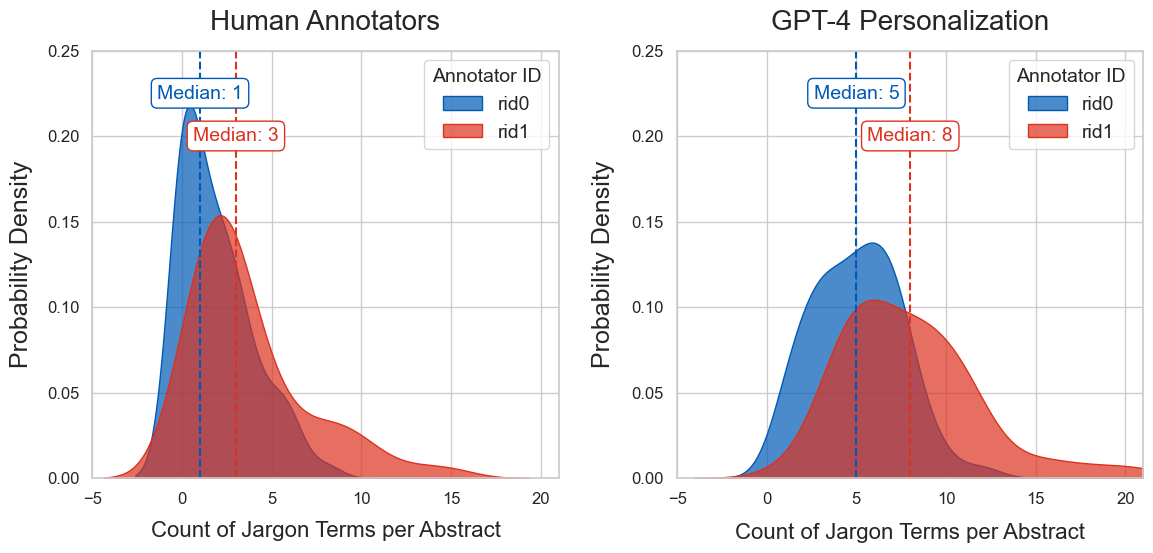

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Determine the common x and y limits
x_min = -5
x_max = max(df['len_gpt_jargon'].max(), df['len_human_jargon'].max())
y_min = 0
y_max = 0.25

# Set the tick positions and labels
x_ticks = range(int(x_min), int(x_max) + 1, 5)  # Adjust the step size as needed
# y_ticks = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12]  # Adjust the step size as needed

# Define colors for each reader
# colors = ['#E69F00', '#56B4E9']  # Orange for rid1, Sky Blue for rid0

# Define colors for each reader
colors = ['#005AB5', '#DC3220']  # blue for rid0, red for rid1

plt.figure(figsize=(12, 6))

# Subplot for human jargon length
plt.subplot(1, 2, 1)
for reader_id, color in zip(df['reader_id'].unique(), colors):
    sns.kdeplot(data=df[df['reader_id'] == reader_id], x='len_human_jargon', fill=True, alpha=0.7, color=color, label=f'rid{int(reader_id[-1])}')

plt.title('Human Annotators', fontsize=20, pad=15)
plt.xlabel('Count of Jargon Terms per Abstract', fontsize=16, labelpad=10)
plt.ylabel('Probability Density', fontsize=18, labelpad=10)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(x_ticks, fontsize=16)
# plt.yticks(y_ticks, fontsize=12)
plt.gca().tick_params(axis='both', which='major', labelsize=12)
plt.legend(title='Annotator ID', title_fontsize=14, fontsize=14)

# Calculate median values for human jargon length
for i, (reader_id, color) in enumerate(zip(df['reader_id'].unique(), colors)):
    median_human = df[df['reader_id'] == reader_id]['len_human_jargon'].median()
    plt.axvline(x=median_human, color=color, linestyle='--', linewidth=1.5)
    plt.text(median_human, y_max * (0.9 - 0.1 * i), f'Median: {int(median_human)}', fontsize=14, color=color,
             ha='center', va='center', bbox=dict(facecolor='white', edgecolor=color, boxstyle='round'))


# Subplot for GPT jargon length
plt.subplot(1, 2, 2)
for reader_id, color in zip(df['reader_id'].unique(), colors):
    sns.kdeplot(data=df[df['reader_id'] == reader_id], x='len_gpt_jargon', fill=True, alpha=0.7, color=color, label=f'rid{int(reader_id[-1])}')

# plt.title('Jargon Identified by GPT-4', fontsize=20, pad=15)
plt.title('GPT-4 Personalization', fontsize=20, pad=15)
plt.xlabel('Count of Jargon Terms per Abstract', fontsize=16, labelpad=12)
plt.ylabel('Probability Density', fontsize=18, labelpad=12)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(x_ticks, fontsize=16)
# plt.yticks(y_ticks, fontsize=12)
plt.gca().tick_params(axis='both', which='major', labelsize=12)
plt.legend(title='Annotator ID', title_fontsize=14, fontsize=14)

# Calculate median values for GPT jargon length
for i, (reader_id, color) in enumerate(zip(df['reader_id'].unique(), colors)):
    median_gpt = df[df['reader_id'] == reader_id]['len_gpt_jargon'].median()
    plt.axvline(x=median_gpt, color=color, linestyle='--', linewidth=1.5)
    plt.text(median_gpt, y_max * (0.9 - 0.1 * i), f'Median: {int(median_gpt)}', fontsize=14, color=color,
             ha='center', va='center', bbox=dict(facecolor='white', edgecolor=color, boxstyle='round'))


plt.tight_layout(pad=2.0)
plt.savefig('figs/humanvsgpt_kdeplot.png', dpi=300, bbox_inches='tight')
plt.show()

Do a Wilcoxon signed-rank test to see if the sample from population for len_gpt_jargon is greater than len_human_jargon, for each rader. Since this is paired data (for each reader, for each abstract, you have this).

In [28]:
import pandas as pd
from scipy.stats import wilcoxon

# Group the data by reader_id and calculate the median differences
median_diffs = df.groupby('reader_id').apply(lambda x: x['len_gpt_jargon'].median() - x['len_human_jargon'].median()).reset_index(name='median_diff')

print("Median differences (len_gpt_jargon - len_human_jargon) for each reader:")
print(median_diffs)

# Perform Wilcoxon signed-rank test for each reader
p_values = df.groupby('reader_id').apply(lambda x: wilcoxon(x['len_gpt_jargon'], x['len_human_jargon'])).reset_index(name='wilcoxon_result')
p_values['p_value'] = p_values['wilcoxon_result'].apply(lambda x: x[1])

print("\nWilcoxon signed-rank test p-values for each reader:")
print(p_values[['reader_id', 'p_value']])

Median differences (len_gpt_jargon - len_human_jargon) for each reader:
  reader_id  median_diff
0      rid0          4.0
1      rid1          5.0

Wilcoxon signed-rank test p-values for each reader:
  reader_id       p_value
0      rid0  1.350370e-09
1      rid1  6.817292e-11


/var/folders/5y/b4h6jbjn4y57lpgqtmtjb5240000gq/T/ipykernel_57123/1390841816.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  median_diffs = df.groupby('reader_id').apply(lambda x: x['len_gpt_jargon'].median() - x['len_human_jargon'].median()).reset_index(name='median_diff')
/var/folders/5y/b4h6jbjn4y57lpgqtmtjb5240000gq/T/ipykernel_57123/1390841816.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  p_v

In [50]:
# import pandas as pd
# from scipy.stats import wilcoxon

# # Calculate the percentage difference between len_gpt_jargon and len_human_jargon for each row
# df['pct_diff'] = (df['len_gpt_jargon'] - df['len_human_jargon']) / df['len_human_jargon'] * 100

# # Group the data by reader_id and calculate the median percentage differences
# median_pct_diffs = df.groupby('reader_id')['pct_diff'].median().reset_index(name='median_pct_diff')

# print("Median percentage differences ((len_gpt_jargon - len_human_jargon) / len_human_jargon * 100) for each reader:")
# print(median_pct_diffs)

# # Perform Wilcoxon signed-rank test on the percentage differences for each reader
# p_values = df.groupby('reader_id')['pct_diff'].apply(lambda x: wilcoxon(x, zero_method='pratt')).reset_index(name='wilcoxon_result')
# p_values['p_value'] = p_values['wilcoxon_result'].apply(lambda x: x[1])

# print("\nWilcoxon signed-rank test p-values for each reader:")
# print(p_values[['reader_id', 'p_value']])

In [31]:
# Counts of instances where no jargon was reported
jargon_identify_eval_df.loc[
    jargon_identify_eval_df['len_human_jargon']==0
].shape

(28, 12)

In [ ]:
# # Set the style of seaborn
# sns.set(style="whitegrid")

# # Create a boxplot for len_gpt_jargon for each reader_id
# plt.figure(figsize=(4, 6))
# sns.boxplot(
#     data=jargon_identify_eval_df, 
#     y='len_gpt_jargon',
#     hue='reader_id', 
#     palette='colorblind', 
#     width=0.5, 
#     gap=0.1
# )
# plt.xlabel('Reader ID')
# plt.ylabel('Length of GPT Jargon')
# plt.title('Length of GPT Jargon by Reader ID')

# # Manually set integer yticks
# plt.yticks(np.arange(0, 25, 2))


# plt.show()

In [ ]:
# # Set the style of seaborn
# sns.set(style="whitegrid")

# # Create a boxplot for len_gpt_jargon for each reader_id
# plt.figure(figsize=(4, 6))
# sns.boxplot(
#     data=jargon_identify_eval_df, 
#     y='len_human_jargon',
#     hue='reader_id', 
#     palette='colorblind', 
#     width=0.5, 
#     gap=0.1
# )
# plt.xlabel('Reader ID')
# plt.ylabel('Length of Annotated Jargon')
# plt.title('Length of Annotated Jargon by Reader ID')

# # Manually set integer yticks
# plt.yticks(np.arange(0, 25, 2))


# plt.show()

In [ ]:
# # Set the style of seaborn
# sns.set(style="whitegrid")

# # Create a boxplot for len_gpt_jargon for each reader_id
# plt.figure(figsize=(4, 6))
# sns.boxplot(
#     data=jargon_identify_eval_df, 
#     y='len_jargon_diff',
#     hue='reader_id', 
#     palette='colorblind', 
#     width=0.5, 
#     gap=0.1
# )
# plt.xlabel('Reader ID')
# plt.ylabel('Length of GPT Jargon')
# plt.title('Length of GPT Jargon by Reader ID')

# # Manually set integer yticks
# # plt.yticks(np.arange(0, 25, 2))


# plt.show()

In [ ]:
# # Set the style of seaborn
# sns.set(style="whitegrid")

# # Create a boxplot for len_gpt_jargon for each reader_id
# plt.figure(figsize=(4, 6))
# sns.boxplot(
#     data=jargon_identify_eval_df, 
#     y='len_jargon_diff',
#     #hue='reader_id', 
#     #palette='colorblind', 
#     width=0.5, 
#     gap=0.1
# )
# plt.xlabel('Reader ID')
# plt.ylabel('Length of GPT Jargon')
# plt.title('Length of GPT Jargon by Reader ID')

# # Manually set integer yticks
# # plt.yticks(np.arange(0, 25, 2))


# plt.show()

In [32]:
# Test if diffs are normal
from scipy import stats
_, p_value = stats.shapiro(jargon_identify_eval_df['len_jargon_diff'])
print(f"Shapiro-Wilk p-value: {p_value:.4f}")

Shapiro-Wilk p-value: 0.0034


p-value less than 0.05, we reject the null. The distribution is not normal.

In [33]:
# Do a Wilcoxon signed-rank test
_, p_value = stats.wilcoxon(jargon_identify_eval_df['len_gpt_jargon'], jargon_identify_eval_df['len_human_jargon'])
print(f"Wilcoxon signed-rank test p-value: {p_value:.4f}")

Wilcoxon signed-rank test p-value: 0.0000


p-value less than 0.05, we reject the null. The distributions are significantly different.

In [34]:
differences = [gpt_len - human_len for human_len, gpt_len in zip(jargon_identify_eval_df['len_human_jargon'], jargon_identify_eval_df['len_gpt_jargon'])]
median_diff = np.median(differences)
print(f"Median difference: {median_diff:.4f}")


Median difference: 4.0000


## Precision and Recall

In [36]:
jargon_identify_eval_df_melted = pd.melt(
    jargon_identify_eval_df[['arxiv_id', 'reader_id', 'precision', 'recall', 'f1_score', 'f2_score', 'len_human_jargon']], 
    id_vars = ['arxiv_id', 'reader_id', 'len_human_jargon'], 
    value_vars = ['precision', 'recall', 'f1_score', 'f2_score']
)
jargon_identify_eval_df_melted.head()


,arxiv_id,reader_id,len_human_jargon,variable,value
0,2403.16190v1,rid0,3,precision,0.333333
1,2403.16190v1,rid1,3,precision,0.333333
2,2307.05300v4,rid0,2,precision,0.000000
3,2307.05300v4,rid1,3,precision,0.166667
4,2403.16750v1,rid0,6,precision,0.833333


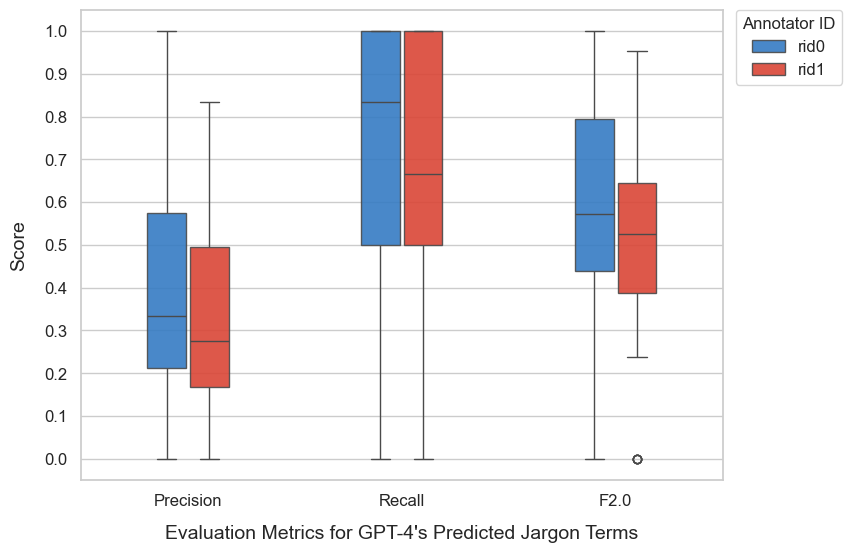

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define colors for each reader
# colors = ['#005AB5', '#DC3220']  # blue for rid0, red for rid1
# Create a custom color palette
custom_palette = sns.color_palette(['#1E7BDA', '#F5301B'])

# Create the grouped bar plot
plt.figure(figsize=(9, 6))
ax = sns.boxplot(
    data=jargon_identify_eval_df_melted.loc[
        (jargon_identify_eval_df_melted['len_human_jargon']>0) &
        (jargon_identify_eval_df_melted['variable']!='f1_score')
    ], 
    y='value', 
    x='variable', 
    hue='reader_id', 
    width=0.4, 
    gap=0.1, 
    dodge=True, 
    palette=custom_palette,  # Set the color palette
    boxprops=dict(alpha=0.9)
)
plt.xlabel("Evaluation Metrics for GPT-4's Predicted Jargon Terms", fontsize=14, labelpad=12)
plt.ylabel('Score', fontsize=14, labelpad=12)
# plt.title("Evaluating GPT4's Jargon Identification", fontsize=16, pad=20)

# Set the x-tick labels
x_labels = ['Precision', 'Recall', 'F2.0']
plt.xticks(range(len(x_labels)), x_labels, rotation=0, fontsize=12)

plt.yticks(np.arange(0, 1.1, 0.1), fontsize=12)

# Modify the legend title
plt.legend(title='Annotator ID', title_fontsize=12, fontsize=12, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout(pad=2.0)
plt.savefig('figs/prf2_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

In [55]:
print("Median recall for rid0:")
print(jargon_identify_eval_df_melted.loc[
        (jargon_identify_eval_df_melted['len_human_jargon']>0) &
        (jargon_identify_eval_df_melted['variable']==0'recall') &
        (jargon_identify_eval_df_melted['reader_id']=='rid0')

    ]['value'].median())

Median recall for rid0:
0.8333333333333334


In [56]:
print("Median recall for rid1:")
print(jargon_identify_eval_df_melted.loc[
        (jargon_identify_eval_df_melted['len_human_jargon']>0) &
        (jargon_identify_eval_df_melted['variable']=='recall') &
        (jargon_identify_eval_df_melted['reader_id']=='rid1')

    ]['value'].median())

Median recall for rid1:
0.6666666666666666


In [57]:
print("Median recall for all:")
print(jargon_identify_eval_df_melted.loc[
        (jargon_identify_eval_df_melted['len_human_jargon']>0) &
        (jargon_identify_eval_df_melted['variable']=='recall')
    ]['value'].median())

Median recall for all:
0.6833333333333333


In [75]:
print("Median precision for all:")
print(jargon_identify_eval_df_melted.loc[
        (jargon_identify_eval_df_melted['len_human_jargon']>0) &
        (jargon_identify_eval_df_melted['variable']=='precision')
    ]['value'].median())

Median precision for all:
0.3333333333333333


In [76]:
print("Median precision for rid0:")
print(jargon_identify_eval_df_melted.loc[
        (jargon_identify_eval_df_melted['len_human_jargon']>0) &
        (jargon_identify_eval_df_melted['variable']=='precision') &
        (jargon_identify_eval_df_melted['reader_id']=='rid0')

    ]['value'].median())

Median precision for rid0:
0.3333333333333333


In [74]:
print("Median precision for rid1:")
print(jargon_identify_eval_df_melted.loc[
        (jargon_identify_eval_df_melted['len_human_jargon']>0) &
        (jargon_identify_eval_df_melted['variable']=='precision') &
        (jargon_identify_eval_df_melted['reader_id']=='rid1')

    ]['value'].median())

Median precision for rid1:
0.2761904761904762


In [116]:
print("Median F2 for all:")
print(jargon_identify_eval_df_melted.loc[
        (jargon_identify_eval_df_melted['len_human_jargon']>0) &
        (jargon_identify_eval_df_melted['variable']=='f2_score')
    ]['value'].median())

print("Median F2 for rid0:")
print(jargon_identify_eval_df_melted.loc[
        (jargon_identify_eval_df_melted['len_human_jargon']>0) &
        (jargon_identify_eval_df_melted['variable']=='f2_score') &
        (jargon_identify_eval_df_melted['reader_id']=='rid0')

    ]['value'].median())

print("Median F2 for rid1:")
print(jargon_identify_eval_df_melted.loc[
        (jargon_identify_eval_df_melted['len_human_jargon']>0) &
        (jargon_identify_eval_df_melted['variable']=='f2_score') &
        (jargon_identify_eval_df_melted['reader_id']=='rid1')

    ]['value'].median())

Median F2 for all:
0.5495169082125604
Median F2 for rid0:
0.5718954248366013
Median F2 for rid1:
0.5263157894736843


## Length of Individual Jargon Terms

In [38]:
# Maintain a list of jargon terms individually instead of in a list
jargon_terms_individual = []

# Iterate and operate
for idx, row in merged_humam_llm_jargon.iterrows():

    # Get both lists
    gpt_list = row['gpt4_jargon_list']
    human_list = row['human_jargon_list']
    # Convert to actual lists
    human_list = [i.strip() for i in human_list.split(',') if i.strip()]
    gpt_list = [i.strip() for i in gpt_list.split(',')]

    # Begin appending
    for term in human_list:
        jargon_terms_individual.append(
            {
                'arxiv_id': row['arxiv_id'],
                'reader_id': row['reader_id'],
                'jargon_term': term, 
                'len_jargon_term': len(term.split(' ')),
                'source_jargon_term': 'human'
            }
        
        )
    for term in gpt_list:
        jargon_terms_individual.append(
            {
                'arxiv_id': row['arxiv_id'],
                'reader_id': row['reader_id'],
                'jargon_term': term, 
                'len_jargon_term': len(term.split(' ')),
                'source_jargon_term': 'gpt'
            }
        
        )

# Convert to DF
jargon_terms_individual_df = pd.DataFrame(jargon_terms_individual)
jargon_terms_individual_df.head()

,arxiv_id,reader_id,jargon_term,len_jargon_term,source_jargon_term
0,2403.16190v1,rid0,correctness,1,human
1,2403.16190v1,rid0,minimality,1,human
2,2403.16190v1,rid0,Anchors,1,human
3,2403.16190v1,rid0,reject option strategy,3,gpt
4,2403.16190v1,rid0,formal guarantees,2,gpt


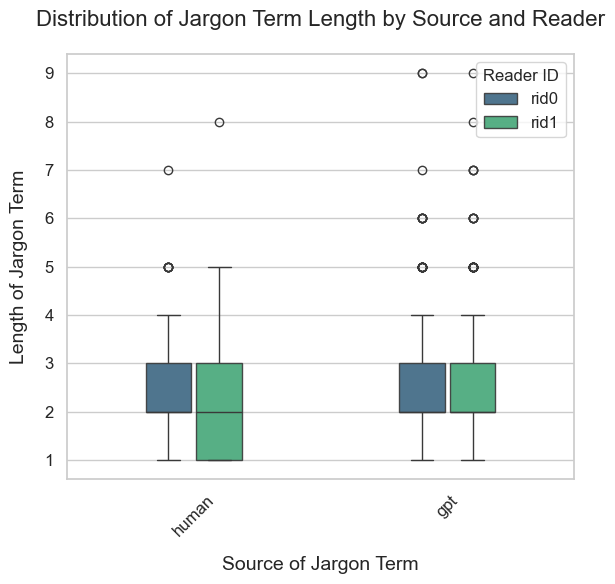

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))

sns.boxplot(
    data=jargon_terms_individual_df, 
    x='source_jargon_term', 
    y='len_jargon_term', 
    hue='reader_id', 
    palette='viridis', 
    width=0.4, 
    gap=0.1,
    dodge=True,  
    boxprops=dict(alpha=0.9)
)

plt.title('Distribution of Jargon Term Length by Source and Reader', fontsize=16, pad=20)
plt.xlabel('Source of Jargon Terms', fontsize=14, labelpad=12)
plt.ylabel('Length of Jargon Terms', fontsize=14, labelpad=12)

plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

plt.legend(title='Reader ID', fontsize=12)

plt.tight_layout()
plt.savefig('boxplot_jargon_term_length_dodged.png', dpi=300, bbox_inches='tight')
plt.show()

In [42]:
jargon_terms_individual_df.sort_values('len_jargon_term', ascending=False).head(10)

,arxiv_id,reader_id,jargon_term,len_jargon_term,source_jargon_term
409,2307.03067v2,rid0,Bio-ML track of the Ontology Alignment Evaluat...,9,gpt
788,2403.10851v1,rid0,wireless earbuds for sensing different eating ...,9,gpt
800,2403.10851v1,rid1,wireless earbuds for sensing different eating ...,9,gpt
685,2403.08451v1,rid1,European Union and Gulf Cooperation Council (G...,8,human
516,2403.16289v1,rid1,prototype of a pipeline of prompts and LLMs,8,gpt
549,2402.01786v2,rid1,militarized version of the StarCraft II game,7,gpt
175,2403.17358v1,rid0,large constrained partially observable Markov ...,7,human
1100,2403.08057v1,rid1,personalized XR user interaction and experienc...,7,gpt
537,2402.01786v2,rid0,militarized version of the StarCraft II game,7,gpt
191,2403.17358v1,rid1,constrained partially observable Markov decisi...,7,gpt


In [58]:
# Do the shapiro wilk on human vs. gpt len_jargon_term for entire dataset
from scipy.stats import mannwhitneyu

dist1 = jargon_terms_individual_df.loc[
    (jargon_terms_individual_df['source_jargon_term']=='human') 
]['len_jargon_term'].tolist()  # Data for distribution 1
dist2 = jargon_terms_individual_df.loc[
    (jargon_terms_individual_df['source_jargon_term']=='gpt') 
]['len_jargon_term'].tolist()    # Data for distribution 2

# Perform the Mann-Whitney U test
statistic, p_value = mannwhitneyu(dist1, dist2)

# Calculate the median difference
median_diff = np.median(dist1) - np.median(dist2)

# Print the results
print("Mann-Whitney U test:")
print(f"Statistic: {statistic}")
print(f"p-value: {p_value}")

# Interpret the results
alpha = 0.05  # Significance level
if p_value < alpha:
    print("The two distributions are significantly different.")
    if median_diff > 0:
        print(f"On average, values from distribution 1 are {median_diff} units greater than values from distribution 2.")
    else:
        print(f"On average, values from distribution 2 are {abs(median_diff)} units greater than values from distribution 1.")
else:
    print("The two distributions are not significantly different.")

Mann-Whitney U test:
Statistic: 131235.0
p-value: 0.0008107229811835362
The two distributions are significantly different.
On average, values from distribution 2 are 0.0 units greater than values from distribution 1.


In [65]:
# Do the shapiro wilk on human vs. gpt len_jargon_term for each reader
from scipy.stats import mannwhitneyu

dist1 = jargon_terms_individual_df.loc[
    (jargon_terms_individual_df['source_jargon_term']=='human') &
    (jargon_terms_individual_df['reader_id']=='rid1')
]['len_jargon_term'].tolist()  # Data for distribution 1
dist2 = jargon_terms_individual_df.loc[
    (jargon_terms_individual_df['source_jargon_term']=='gpt') &
    (jargon_terms_individual_df['reader_id']=='rid1')
]['len_jargon_term'].tolist()    # Data for distribution 2

# Perform the Mann-Whitney U test
statistic, p_value = mannwhitneyu(dist1, dist2)

# Calculate the median difference
mean_diff = np.mean(dist1) - np.mean(dist2)

# Print the results
print("Mann-Whitney U test:")
print(f"Statistic: {statistic}")
print(f"p-value: {p_value}")

# Interpret the results
alpha = 0.01  # Significance level
if p_value < alpha:
    print("The two distributions are significantly different.")
    if mean_diff > 0:
        print(f"On average, values from distribution 1 are {mean_diff} units greater than values from distribution 2.")
    else:
        print(f"On average, values from distribution 2 are {abs(mean_diff)} units greater than values from distribution 1.")
else:
    print("The two distributions are not significantly different.")

Mann-Whitney U test:
Statistic: 49069.0
p-value: 1.548611256487033e-05
The two distributions are significantly different.
On average, values from distribution 2 are 0.31615476466881187 units greater than values from distribution 1.


# Exploring the Low Recall Cases

In [ ]:
# Get the low recall abstracts out
low_recall_abstracts = jargon_identify_eval_df.loc[
    jargon_identify_eval_df['recall'] < 0.5
]

print(low_recall_abstracts.shape)

# Add abstract metadata
low_recall_abstracts = pd.merge(
    low_recall_abstracts, metadata_df, on='arxiv_id'
)

# Add in the merged_humam_llm_jargon
low_recall_abstracts = pd.merge(
    low_recall_abstracts, merged_humam_llm_jargon, on=['arxiv_id', 'reader_id']
)

low_recall_abstracts.to_json(
    f'data/llm_outputs/{today}_march_2024_sampled_jargon_identify_eval_metrics_low_recall.json', 
    orient='index'
)

In [ ]:
low_recall_abstracts.value_counts('reader_id')

In [ ]:
# Get the low prec abstracts out
low_prec_abstracts = jargon_identify_eval_df.loc[
    jargon_identify_eval_df['precision'] < 0.25
]

# Add abstract metadata
low_prec_abstracts = pd.merge(
    low_prec_abstracts, metadata_df, on='arxiv_id'
)

# Add in the merged_humam_llm_jargon
low_prec_abstracts = pd.merge(
    low_prec_abstracts, merged_humam_llm_jargon, on=['arxiv_id', 'reader_id']
)

low_prec_abstracts.to_json(
    f'data/llm_outputs/{today}_march_2024_sampled_jargon_identify_eval_metrics_low_prec.json', 
    orient='index'
)

In [ ]:
low_prec_abstracts.value_counts('reader_id')

# Exploring the Low Precision Cases

In [97]:
# Get the low recall abstracts out + Make sure it's stuff w/ at least one human annotated jargon term
low_prec_abstracts = jargon_identify_eval_df.loc[
    (jargon_identify_eval_df['precision'] <= 0.15) & 
    (jargon_identify_eval_df['len_human_jargon'] >0 )
]

# Add abstract metadata
low_prec_abstracts = pd.merge(
    low_prec_abstracts, metadata_df, on='arxiv_id'
)

# Add in the merged_humam_llm_jargon
low_prec_abstracts = pd.merge(
    low_prec_abstracts, merged_humam_llm_jargon, on=['arxiv_id', 'reader_id']
)



print(low_prec_abstracts.shape)

low_prec_abstracts.to_json(
    f'data/llm_outputs/{today}_march_2024_sampled_jargon_identify_eval_metrics_low_prec.json', 
    orient='index'
)

(20, 27)


In [98]:
# how many of each annotator
low_prec_abstracts.value_counts('reader_id')

reader_id
rid1    12
rid0     8
Name: count, dtype: int64

In [112]:
# what is the mean length of human jargon
low_prec_abstracts.groupby('reader_id')['len_human_jargon'].mean()

reader_id
rid0    1.625000
rid1    1.916667
Name: len_human_jargon, dtype: float64

In [113]:
# what is the mean length of gpt jargon
low_prec_abstracts.groupby('reader_id')['len_gpt_jargon'].mean()

reader_id
rid0    6.125000
rid1    9.833333
Name: len_gpt_jargon, dtype: float64

In [111]:
# what is the median length of human jargon 
low_prec_abstracts.groupby('reader_id')['len_human_jargon'].median()

reader_id
rid0    1.5
rid1    2.0
Name: len_human_jargon, dtype: float64

In [114]:
# what is the median length of gpt jargon 
low_prec_abstracts.groupby('reader_id')['len_gpt_jargon'].median()

reader_id
rid0    7.0
rid1    9.0
Name: len_gpt_jargon, dtype: float64